In [1]:
%matplotlib inline
import brine
import cv2
import numpy as np
from model.augmentations import randomHueSaturationValue, randomShiftScaleRotate, randomHorizontalFlip
import model.u_net as unet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [ ]:
!brine install rohan/chairs-with-masks

In [2]:
chairs = brine.load_dataset('rohan/chairs-with-masks')

In [3]:
print('Dataset size:', len(chairs))
print('Columns:', chairs.columns)
print(chairs[23])

Dataset size: 97
Columns: Column(image=Column(name=image, type=Image), mask=Column(name=mask, type=Image))
Row(image='59.jpg', mask='59_mask.png')


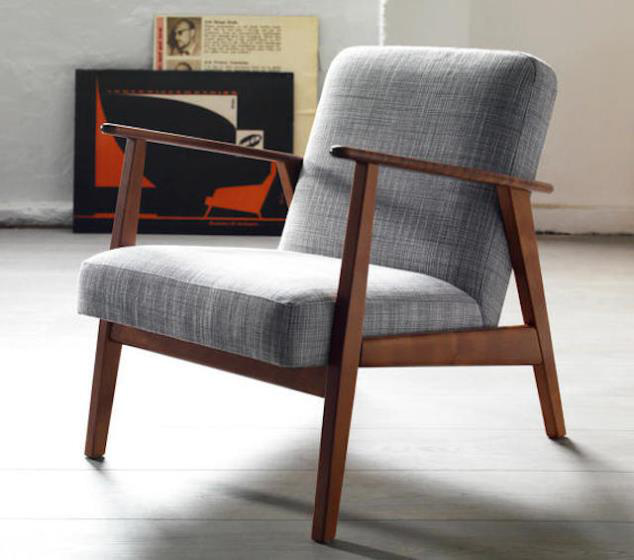

In [4]:
chairs.load_image(chairs[23].image)

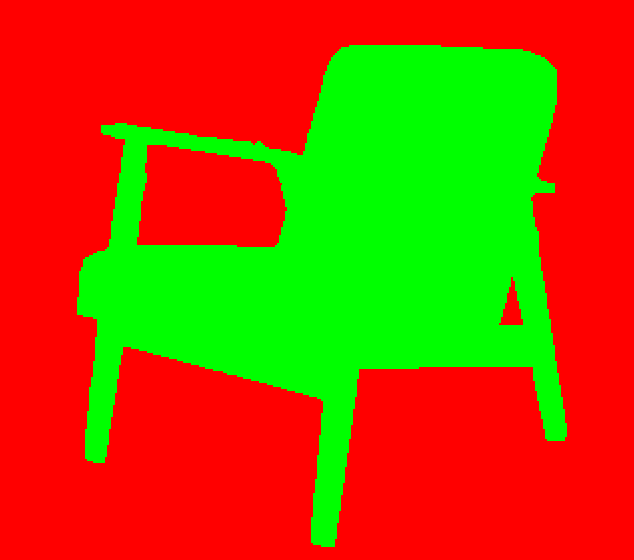

In [5]:
chairs.load_image(chairs[23].mask)

In [6]:
model = unet.get_unet_256(num_classes=1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
SIZE = (256, 256)

In [8]:
# Method to set grayscale mask values to either 0 or 255
def fix_mask(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0

In [9]:
# Processing function for the training data
def train_process(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-50, 50),
                                   sat_shift_limit=(0, 0),
                                   val_shift_limit=(-15, 15))
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.0625, 0.0625),
                                       scale_limit=(-0.1, 0.1),
                                       rotate_limit=(-20, 20))
    img, mask = randomHorizontalFlip(img, mask)
    fix_mask(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

In [10]:
# Processing function for the validation data, no data augmentation
def validation_process(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    fix_mask(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

In [11]:
BATCH_SIZE = 1

In [12]:
validation_fold, train_fold = chairs.create_folds((20,))
print('Validation fold size:', len(validation_fold))
print('Train fold size:', len(train_fold))

Validation fold size: 20
Train fold size: 77


In [13]:
train_generator = train_fold.to_keras('image',  
                                      'mask',   
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      processing_function=train_process)

In [14]:
validation_generator = validation_fold.to_keras('image',
                                                'mask',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                processing_function=validation_process)

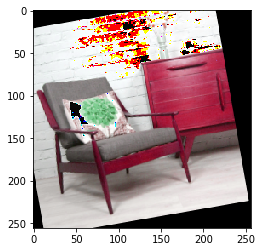

In [15]:
image, mask = next(train_generator)
plt.imshow(image[0])

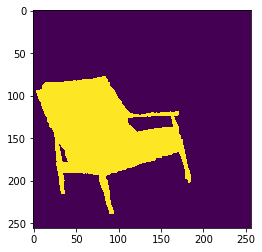

In [16]:
plt.imshow(mask[0].reshape(SIZE))

In [17]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

In [19]:
epochs=100
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.steps_per_epoch())

Epoch 1/100
77/77 [==============================] - ETA: 0s - loss: 0.7248 - dice_coeff: 0.6672 - val_loss: 1.1701 - val_dice_coeff: 0.3705
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.6737 - dice_coeff: 0.6908 - val_loss: 1.5078 - val_dice_coeff: 0.2359
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 0.6161 - dice_coeff: 0.7168 - val_loss: 1.0897 - val_dice_coeff: 0.4578
Epoch 4/100
77/77 [==============================] - ETA: 0s - loss: 0.5877 - dice_coeff: 0.7298 - val_loss: 0.9901 - val_dice_coeff: 0.5505
Epoch 5/100
77/77 [==============================] - ETA: 0s - loss: 0.5458 - dice_coeff: 0.7472 - val_loss: 0.9400 - val_dice_coeff: 0.6893
Epoch 6/100
77/77 [==============================] - ETA: 0s - loss: 0.5085 - dice_coeff: 0.7643 - val_loss: 0.6679 - val_dice_coeff: 0.7305
Epoch 7/100
77/77 [==============================] - ETA: 0s - loss: 0.4744 - dice_coeff: 0.7792 - val_loss: 0.7548 - val_dice_coeff: 0.7160
Epoch 8/100
7

In [20]:
model.load_weights('weights/best_weights.hdf5')

In [21]:
def predict_one():
    image_batch, mask_batch = next(validation_generator)
    predicted_mask_batch = model.predict(image_batch)
    image = image_batch[0]
    predicted_mask = predicted_mask_batch[0].reshape(SIZE)
    plt.imshow(image)
    plt.imshow(predicted_mask, alpha=0.6)

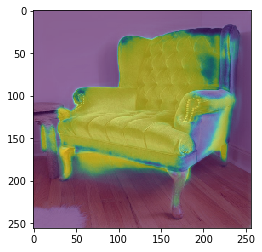

In [26]:
predict_one()